# Lab 4: Fine-Tuning a Pre-trained CNN for Custom Image Recognition


### Objective
This lab introduces students to the practical application of transfer learning in deep learning, specifically focusing on fine-tuning pre-trained Convolutional Neural Networks (CNNs) for electronic gadget classification. Students will understand when and how to use transfer learning, explore popular pre-trained models, and learn the process of fine-tuning these models for custom image recognition tasks.

### Dataset information
We use Elctronics gadgets images for image classification.

### Classes
1. Laptop
2. Camera

###  Tasks
1. **Setup and Data Preparation**

    - Set up the working environment
    - Install required dependencies
    - Download and explore the dataset
    - Create data loaders and apply necessary transformations

2. **Understanding Pre-trained Models**

    - Load ResNet pre-trained on ImageNet
    - Explore model architecture and parameters
    - Visualize and understand feature maps from different layers
    - Run inference using the pre-trained model without fine-tuning

3. **Training and Evaluation**

    - Implement the training loop with proper loss function and optimizer
    - Monitor training progress
    - Visualize results and model predictions

### Import required libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

### Data transformation and preprocessing

In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


### Loading dataset from folder

In [5]:
data_dir = 'LAB_4_Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['camera', 'laptop']


### Sample data

In [6]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

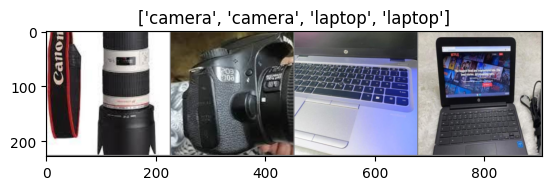

In [7]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Loading pre-trained model

In [8]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

d:\Nokia_DL_L3_lab\nokia\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Nokia_DL_L3_lab\nokia\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Model architecture

In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training loop

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    train_loss = []
    validation_loss = []
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Training Phase
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over training data
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # scheduler.step()

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        
        train_loss.append(epoch_loss)

        print('Training Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print()

        # Validation Phase
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over validation data
        with torch.no_grad():
            for inputs, labels in dataloaders['valid']:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / dataset_sizes['valid']
        val_acc = running_corrects.double() / dataset_sizes['valid']

        validation_loss.append(val_loss)
        print('Validation Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, train_loss, validation_loss

In [ ]:
model, train_loss, val_loss = train_model(model, criterion, optimizer, num_epochs=10)


Epoch 0/9
----------
Training Loss: 0.6754 Acc: 0.6122

Validation Loss: 0.5972 Acc: 0.6667
Epoch 1/9
----------
Training Loss: 0.4769 Acc: 0.7891

Validation Loss: 0.2146 Acc: 1.0000
Epoch 2/9
----------
Training Loss: 0.3792 Acc: 0.8639

Validation Loss: 0.1624 Acc: 1.0000
Epoch 3/9
----------
Training Loss: 0.3286 Acc: 0.8776

Validation Loss: 0.0992 Acc: 1.0000
Epoch 4/9
----------
Training Loss: 0.3403 Acc: 0.8367

Validation Loss: 0.0853 Acc: 1.0000
Epoch 5/9
----------
Training Loss: 0.2247 Acc: 0.9320

Validation Loss: 0.0657 Acc: 1.0000
Epoch 6/9
----------
Training Loss: 0.2614 Acc: 0.9048

Validation Loss: 0.0512 Acc: 1.0000
Epoch 7/9
----------
Training Loss: 0.2928 Acc: 0.8980

Validation Loss: 0.0476 Acc: 1.0000
Epoch 8/9
----------
Training Loss: 0.2599 Acc: 0.8980

Validation Loss: 0.0416 Acc: 1.0000
Epoch 9/9
----------
Training Loss: 0.2953 Acc: 0.9116

Validation Loss: 0.0382 Acc: 1.0000
Best val Acc: 1.000000


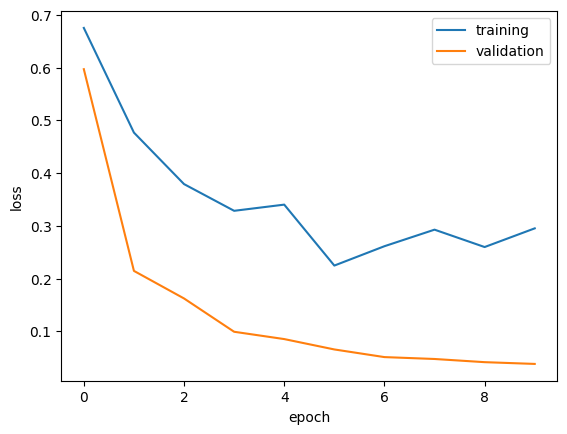

In [14]:
plt.figure()
plt.plot(np.arange(10), train_loss)
plt.plot(np.arange(10), val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Test on Testin Dataset

In [11]:
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])

dataloaders = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

In [12]:
len(test_dataset)

13

In [13]:
def predict_img(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    
    _, pred = torch.max(yb, dim=1)
    return pred    

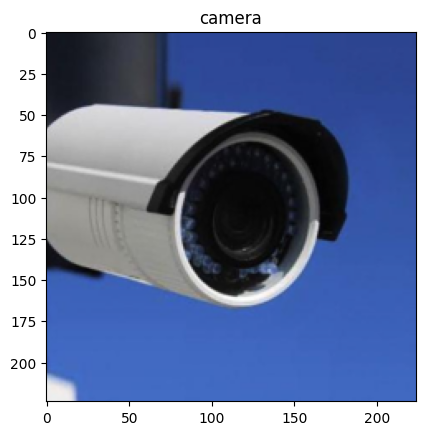

Label: camera , Predicted: laptop


In [14]:
img, label = test_dataset[0]
imshow(img, class_names[label])
print('Label:', class_names[label], ', Predicted:', class_names[predict_img(img, model).item()])

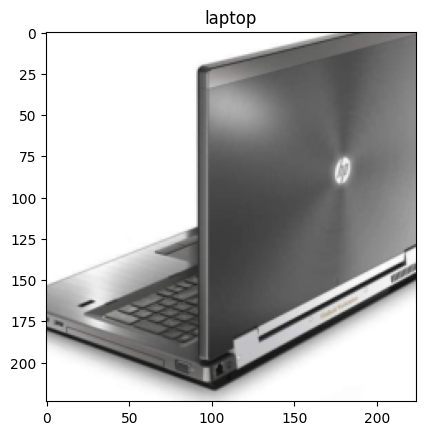

Label: laptop , Predicted: laptop


In [15]:
img, label = test_dataset[9]
imshow(img, class_names[label])
print('Label:', class_names[label], ', Predicted:', class_names[predict_img(img, model).item()])